<a href="https://colab.research.google.com/github/r-ogrady/demos_vis_geospatial/blob/main/c12_train_MNIST_nosie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes
* **Purpose:** train MNIST data with noisy data, different lrs

In [2]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import copy
import random
from google.colab import drive
import sys
from torchvision import datasets
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary

# Mount drive

In [4]:
# in colab - mount drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Dissertation/code'

Mounted at /content/drive/
/content/drive/My Drive/Dissertation/code


In [5]:
sys.path.append("drive/My Drive/Dissertation/code")
from b01_cpl import CorrelationPenaltyLoss
from b02_models import LeNet5
from b03_plotters import plotter0, plotter, plotter_corr

# Helper functions and initialisations
For training, plotting training metrics and checking accuracy on test set

In [6]:
# random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
generator1=torch.Generator().manual_seed(42)


In [7]:
# trainer with my loss
def trainer0(n_epochs,lrs,train_dataloader,val_dataloader):

    # storage
    # data dict for storing metrics per lr and epoch
    epoch_keys=["train_losses","train_accuracies",
                "val_losses","val_accuracies","time"]
    data_dict={lr:
      {key:[] for key in epoch_keys} for lr in lrs}
    # storing models
    models = []

    # we train a new model for each lr value
    for i,lr in enumerate(lrs):
        # load model for each loop
        model = LeNet5().to(device)
        optimizer = optim.Adam(params = model.parameters(),lr=lr)
        criterion = nn.CrossEntropyLoss()

        # initialise variables for EarlyStopping
        best_loss = float('inf')
        best_model_weights = None
        patience = 10


        print(f"training for lr = {lr}")

        for epoch in range(n_epochs):
            t0 = time.time()
            # initialise variables for recording training loss and accuracy
            running_loss = 0.0
            running_loss_base = 0.0
            running_correct = 0
            running_total = 0

            model.train()
            for input,labels in train_dataloader:
                desired_labels=labels[0]

                input = input.to(device)
                desired_labels = desired_labels.to(device)


                optimizer.zero_grad()
                output = model(input)
                loss = criterion(output,desired_labels)
                loss.backward()
                optimizer.step()

                # training loss and accuracy for batch
                # this is scaled by the batch size and divided back later
                running_loss += loss.item() * input.size(0)

                _, predicted = torch.max(output.data, 1)
                running_total += desired_labels.size(0)
                running_correct += (predicted == desired_labels).sum().item()

            # training loss and accuracy for epoch (scaled back)
            train_loss = running_loss/len(train_dataloader.dataset)

            train_accuracy = 100 * running_correct/running_total

            # store
            epoch_dict=data_dict[lr]
            epoch_dict["train_losses"].append(train_loss)

            epoch_dict["train_accuracies"].append(train_accuracy)

            # initialise variables for recording val loss and accuracy
            val_running_loss = 0.0
            val_running_correct = 0
            val_running_total = 0

            model.eval()
            with torch.no_grad():
                for input,labels in val_dataloader:
                    desired_labels=labels[0]
                    orthog_labels=labels[1]
                    input = input.to(device)
                    desired_labels = desired_labels.to(device)
                    orthog_labels = orthog_labels.to(device)

                    output = model(input)

                    # validation loss and accuracy for batch
                    val_running_loss += criterion(output,desired_labels).item() * desired_labels.size(0)

                    _, predicted = torch.max(output.data, 1)
                    val_running_total += desired_labels.size(0)
                    val_running_correct += (predicted == desired_labels).sum().item()


            # validation loss and accuracy for epoch
            val_loss = val_running_loss / len(val_dataloader.dataset)

            val_accuracy = 100 * val_running_correct / val_running_total

            # store
            epoch_time=time.time()-t0
            epoch_dict["val_losses"].append(val_loss)

            epoch_dict["val_accuracies"].append(val_accuracy)
            epoch_dict["time"].append(epoch_time)

            # print for epoch
            if epoch % 5 == 0:
                print(f"epoch: {epoch + 1}, time: {epoch_time:0.2f}")
                print("training loss: ",
                      f"{train_loss:0.2f}, accuracy: {train_accuracy:.2f}")
                print("validation loss: ",
                      f"{val_loss:0.2f}, accuracy: {val_accuracy:.2f}")
                print()

            # EarlyStopping
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_weights = copy.deepcopy(model.state_dict())
                patience = 10
            else:
                patience -= 1
                if patience == 0:
                    print(f"Early stop at epoch {epoch+1}\n")
                    break

        # load and store the best model weights
        model.load_state_dict(best_model_weights)
        models.append(model)

    return data_dict, models


In [8]:
# trainer with my loss
def trainer(n_epochs,lrs,alphas,layer_type,train_dataloader,val_dataloader):

    # storage
    # data dict for storing metrics per alpha and epoch
    epoch_keys=["train_losses_base","train_losses_corr","train_losses","train_accuracies",
                "val_losses_base","val_losses_corr","val_losses","val_accuracies","time"]
    alpha_dict={alpha:
      {key:[] for key in epoch_keys} for alpha in alphas}
    lr_dict={lr:alpha_dict for lr in lrs}
    # storing models
    models = [[] for lr in lrs]

    # we train a new batch of models for each lr
    for i,lr in enumerate(lrs):
        print(f"training for lr = {lr}")

    # we train a new model for each alpha value
        for alpha in alphas:
            # load model for each loop
            model = LeNet5().to(device)
            optimizer = optim.Adam(params = model.parameters(),lr=lr)
            criterion = CorrelationPenaltyLoss(model=model,
                                    base_loss_fn=base_loss_fn,
                                    layer_type=layer_type,
                                    alpha=alpha)

            # initialise variables for EarlyStopping
            best_loss = float('inf')
            best_model_weights = None
            patience = 10


            print(f"training for alpha = {alpha}")

            for epoch in range(n_epochs):
                t0 = time.time()
                # initialise variables for recording training loss and accuracy
                running_loss = 0.0
                running_loss_base = 0.0
                running_correct = 0
                running_total = 0

                model.train()
                for input,labels in train_dataloader:
                    desired_labels=labels[0]
                    orthog_labels=labels[1]
                    input = input.to(device)
                    desired_labels = desired_labels.to(device)
                    orthog_labels = orthog_labels.to(device)

                    optimizer.zero_grad()
                    output = model(input)
                    loss = criterion(output,desired_labels,orthog_labels)
                    loss_base = base_loss_fn(output,desired_labels)
                    loss.backward()
                    optimizer.step()

                    # training loss and accuracy for batch
                    # this is scaled by the batch size and divided back later
                    running_loss += loss.item() * input.size(0)
                    running_loss_base += loss_base.item() * input.size(0)
                    _, predicted = torch.max(output.data, 1)
                    running_total += desired_labels.size(0)
                    running_correct += (predicted == desired_labels).sum().item()

                # training loss and accuracy for epoch (scaled back)
                train_loss = running_loss/len(train_dataloader.dataset)
                train_loss_base = running_loss_base/len(train_dataloader.dataset)
                train_loss_corr = (train_loss-train_loss_base)/alpha
                train_accuracy = 100 * running_correct/running_total

                # store
                epoch_dict=alpha_dict[alpha]
                epoch_dict["train_losses"].append(train_loss)
                epoch_dict["train_losses_corr"].append(train_loss_corr)
                epoch_dict["train_losses_base"].append(train_loss_base)
                epoch_dict["train_accuracies"].append(train_accuracy)

                # initialise variables for recording val loss and accuracy
                val_running_loss = 0.0
                val_running_loss_base = 0.0
                val_running_correct = 0
                val_running_total = 0

                model.eval()
                with torch.no_grad():
                    for input,labels in val_dataloader:
                        desired_labels=labels[0]
                        orthog_labels=labels[1]
                        input = input.to(device)
                        desired_labels = desired_labels.to(device)
                        orthog_labels = orthog_labels.to(device)

                        output = model(input)

                        # validation loss and accuracy for batch
                        val_running_loss += criterion(output,desired_labels,orthog_labels).item() * desired_labels.size(0)
                        val_running_loss_base += base_loss_fn(output, desired_labels).item() * desired_labels.size(0)
                        _, predicted = torch.max(output.data, 1)
                        val_running_total += desired_labels.size(0)
                        val_running_correct += (predicted == desired_labels).sum().item()


                # validation loss and accuracy for epoch
                val_loss = val_running_loss / len(val_dataloader.dataset)
                val_loss_base = val_running_loss_base / len(val_dataloader.dataset)
                val_loss_corr = (val_loss-val_loss_base)/alpha
                val_accuracy = 100 * val_running_correct / val_running_total

                # store
                epoch_time=time.time()-t0
                epoch_dict["val_losses"].append(val_loss)
                epoch_dict["val_losses_corr"].append(val_loss_corr)
                epoch_dict["val_losses_base"].append(val_loss_base)
                epoch_dict["val_accuracies"].append(val_accuracy)
                epoch_dict["time"].append(epoch_time)

                # print for epoch
                if epoch % 5 == 0:
                    print(f"epoch: {epoch + 1}, time: {epoch_time:0.2f}")
                    print("training loss (base/corr/combo): ",
                        f"{train_loss_base:0.2f}/{train_loss_corr:0.2f}/{train_loss:0.2f}, accuracy: {train_accuracy:.2f}")
                    print("validation loss (base/corr/combo): ",
                        f"{val_loss_base:0.2f}/{val_loss_corr:0.2f}/{val_loss:0.2f}, accuracy: {val_accuracy:.2f}")
                    print()

                # EarlyStopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model_weights = copy.deepcopy(model.state_dict())
                    patience = 10
                else:
                    patience -= 1
                    if patience == 0:
                        print(f"Early stop at epoch {epoch+1}\n")
                        break

            # load and store the best model weights
            model.load_state_dict(best_model_weights)
            models[i].append(model)
            lr_dict[alpha]=alpha_dict


    return lr_dict, models


In [9]:
# test accuracy of a given model
def tester(models,alphas,test_dataloader,test_type):

    # for storing
    accuracies = torch.zeros(len(models))

    for i,model in enumerate(models):
        num_correct = 0
        num_samples = 0
        model.eval()

        with torch.no_grad():
            if test_type=="raw":
                for input,target in test_dataloader:
                    input,target = input.to(device),target.to(device)
                    scores = model(input)
                    _, predictions = scores.max(1)
                    num_correct +=  (predictions ==  target).sum()
                    num_samples +=  predictions.size(0)
            elif test_type=="cpl":
                for input,target in test_dataloader:
                    target=target[0]
                    input,target = input.to(device),target.to(device)
                    scores = model(input)
                    _, predictions = scores.max(1)
                    num_correct +=  (predictions ==  target).sum()
                    num_samples +=  predictions.size(0)


        accuracy = float(num_correct)/float(num_samples)*100
        accuracies[i] = accuracy

        print(f"Alpha = {alphas[i]} Model:")
        print(f'Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}\n')

    return accuracies

# Load data

In [10]:
# NOTE non-deterministic parts here!

# first we extend the class for the dataset to include the transformation in the getitem call
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class MyMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, download=True):
        self.mnist = datasets.MNIST(root=root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, index):
        img, label = self.mnist[index]

        # implement the transforms in correct order
        # resize and convert to tensor first
        img = T.Resize((32, 32))(img)
        img = T.ToTensor()(img)

        # randomly apply gaussian noise with a given sigma
        noise_sigmas=np.arange(0,0.6,0.1)
        noise_sigma=random.choice(noise_sigmas)
        add_noise=AddGaussianNoise(mean=1,std=noise_sigma)
        new_label=noise_sigma
        img = add_noise(img)

        # normalise after noise/blur has been applied
        img = T.Normalize((0.1307,), (0.3081,))(img)

        # apply additional transformations
        if self.transform:
            img = self.transform(img)

        return img, (label, new_label)

# create noise dataset
noise_dataset=MyMNIST(
    root='./data',
    train=False)

# w/o my orthogonal transform
# import train/test data without orthogonal_action
transform=T.Compose([T.Resize((32,32)),
                    T.ToTensor(),
                    T.Normalize((0.1307,), (0.3081,))
                    ])

raw_test_dataset=datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

Text(0.5, 0.85, 'Noise')

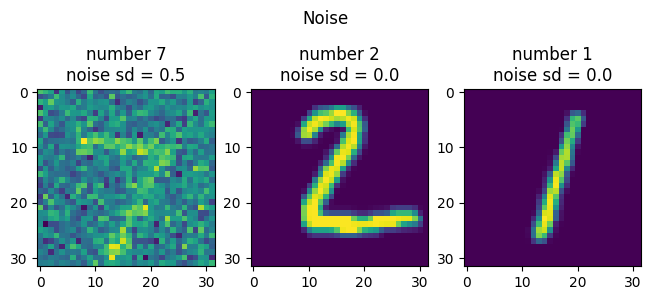

In [11]:
fig,axs=plt.subplots(1,3, constrained_layout=True)
for i in range(3):
    item=noise_dataset[i]
    axs[i].imshow(item[0].squeeze())
    axs[i].set_title(f'number {item[1][0]}\nnoise sd = {item[1][1]:0.1f}')
fig.suptitle("Noise",y=0.85)

In [12]:
# validation split
noise_train_dataset,noise_val_dataset=torch.utils.data.random_split(noise_dataset,[5/6, 1/6],generator=generator1)

# dataloader
noise_train_dataloader = DataLoader(noise_train_dataset, batch_size = 64, shuffle = True,generator = generator1)
noise_val_dataloader = DataLoader(noise_val_dataset, batch_size = 64, shuffle = True,generator = generator1)
raw_test_dataloader = DataLoader(raw_test_dataset, batch_size = 64, shuffle = True,generator = generator1)

# Train

## Use different devices on Colab

In [13]:
# GPU
if torch.cuda.is_available():
    device = "cuda"
    # show GPU details
    !nvidia-smi
else:
    device = "cpu"

print(f"\nUsing {device}")

Mon Aug 19 12:47:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [14]:
model0 = LeNet5().to(device)
# overview of model - enter the input size
summary(model0,(1,32,32),device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
            Linear-9                  [-1, 120]          48,120
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 61,750
Trainable params: 

In [15]:
# lrs for all
lrs=[0.00001,0.00005,0.0001,0.005]

## Train w/o my loss

In [16]:
model02_dict,models02=trainer0(100,lrs,noise_train_dataloader,noise_val_dataloader)

training for lr = 1e-05
epoch: 1, time: 5.47
training loss:  2.29, accuracy: 12.36
validation loss:  2.28, accuracy: 17.95

epoch: 6, time: 5.52
training loss:  2.01, accuracy: 53.16
validation loss:  1.97, accuracy: 53.24

epoch: 11, time: 4.81
training loss:  1.42, accuracy: 72.95
validation loss:  1.39, accuracy: 72.99

epoch: 16, time: 4.27
training loss:  0.97, accuracy: 81.95
validation loss:  0.94, accuracy: 81.33

epoch: 21, time: 4.31
training loss:  0.71, accuracy: 85.75
validation loss:  0.69, accuracy: 85.11

epoch: 26, time: 5.42
training loss:  0.56, accuracy: 87.45
validation loss:  0.55, accuracy: 87.88

epoch: 31, time: 4.49
training loss:  0.47, accuracy: 88.84
validation loss:  0.47, accuracy: 87.58

epoch: 36, time: 4.28
training loss:  0.40, accuracy: 89.96
validation loss:  0.41, accuracy: 89.20

epoch: 41, time: 4.60
training loss:  0.36, accuracy: 90.54
validation loss:  0.36, accuracy: 90.04

epoch: 46, time: 5.29
training loss:  0.33, accuracy: 91.11
validatio

lr = 1e-05


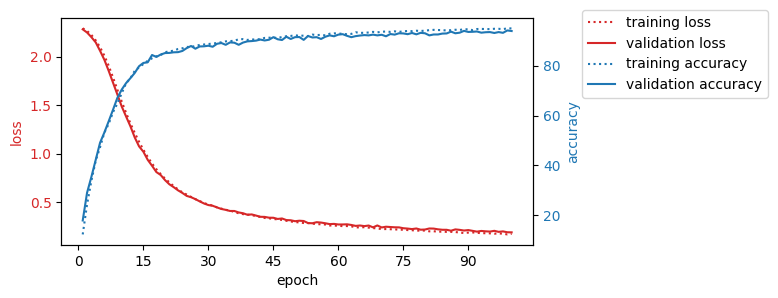


lr = 5e-05


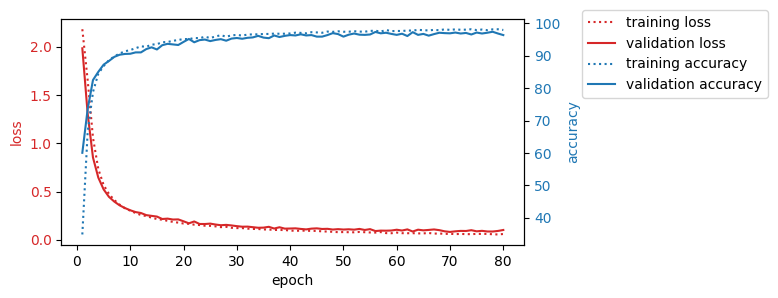


lr = 0.0001


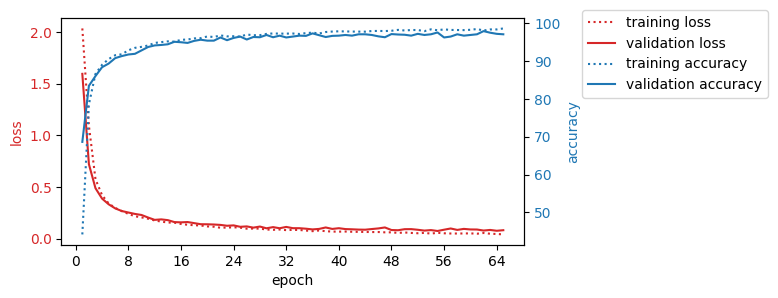


lr = 0.005


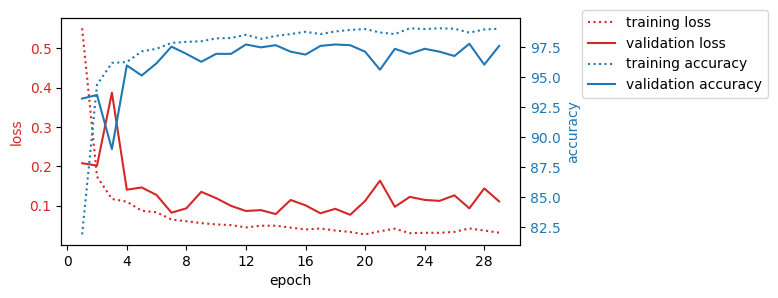

In [17]:
for lr in lrs:
    print(f"lr = {lr}")
    plotter0(model02_dict[lr])
    print()

In [18]:
# model test w/o transform
# accuracy check taken from
# https://discuss.pytorch.org/t/how-to-find-test-accuracy-after-training/88962/3
for i, lr in enumerate(lrs):
    num_correct = 0
    num_samples = 0
    models02[i].eval()

    with torch.no_grad():
        for input,target in raw_test_dataloader:
            input,target = input.to(device),target.to(device)
            scores = models02[i](input)
            _, predictions = scores.max(1)
            num_correct +=  (predictions ==  target).sum()
            num_samples +=  predictions.size(0)

    accuracy=float(num_correct)/float(num_samples)*100
    print(f"lr={lr}")
    print(f'Got {num_correct}/{num_samples} with accuracy {accuracy:0.2f}\n')

lr=1e-05
Got 1293/10000 with accuracy 12.93

lr=5e-05
Got 985/10000 with accuracy 9.85

lr=0.0001
Got 2746/10000 with accuracy 27.46

lr=0.005
Got 2929/10000 with accuracy 29.29



In [19]:
# save
time_stamp=time.strftime("%Y%m%d-%H%M%S")
for i, model in enumerate(models02):
    file_name="model02_lr"+str(lrs[i]).replace(".","point")+"_"+str(time_stamp)
    torch.save(model.state_dict(), f'output/{file_name}.pt')
    print(f"saved model as '{file_name}.pt'")

torch.save(model02_dict, f'output/model12_dict_{time_stamp}.pt')
print(f"saved dictionary as 'model12_dict_{time_stamp}.pt'")

saved model as 'model02_lr1e-05_20240819-131001.pt'
saved model as 'model02_lr5e-05_20240819-131001.pt'
saved model as 'model02_lr0point0001_20240819-131001.pt'
saved model as 'model02_lr0point005_20240819-131001.pt'
saved dictionary as 'model12_dict_20240819-131001.pt'


## Train w/ my loss

In [20]:
# same base loss for all training
# our hyperparameter is alpha - the scalar for the loss
alphas = [0.1,0.5,1,10,50,100]
base_loss_fn = nn.CrossEntropyLoss()

In [22]:
# train
model12_dict,models12=trainer(100,lrs,alphas,"nn.Linear",noise_train_dataloader,noise_val_dataloader)

training for lr = 1e-05
training for alpha = 0.1
epoch: 1, time: 5.59
training loss (base/corr/combo):  2.30/0.08/2.30, accuracy: 11.71
validation loss (base/corr/combo):  2.28/0.07/2.29, accuracy: 15.01

epoch: 6, time: 5.75
training loss (base/corr/combo):  2.00/0.04/2.01, accuracy: 60.56
validation loss (base/corr/combo):  1.96/0.04/1.96, accuracy: 61.88

epoch: 11, time: 6.02
training loss (base/corr/combo):  1.43/0.04/1.43, accuracy: 73.64
validation loss (base/corr/combo):  1.38/0.04/1.39, accuracy: 73.77

epoch: 16, time: 6.19
training loss (base/corr/combo):  0.99/0.03/1.00, accuracy: 80.17
validation loss (base/corr/combo):  0.96/0.03/0.96, accuracy: 79.65

epoch: 21, time: 6.22
training loss (base/corr/combo):  0.73/0.03/0.73, accuracy: 84.57
validation loss (base/corr/combo):  0.70/0.03/0.70, accuracy: 84.51

epoch: 26, time: 6.20
training loss (base/corr/combo):  0.57/0.03/0.57, accuracy: 86.81
validation loss (base/corr/combo):  0.56/0.03/0.56, accuracy: 86.49

epoch: 31, 

In [23]:
# save
time_stamp=time.strftime("%Y%m%d-%H%M%S")
for i, lr_models in enumerate(models12):
    for j,model in enumerate(lr_models):
        file_name="model12_lr"+str(lrs[i]).replace(".","point")+"_alpha"+str(alphas[j]).replace(".","point")+"_"+str(time_stamp)
        torch.save(model.state_dict(), f'output/{file_name}.pt')
        print(f"saved model as '{file_name}.pt'")

torch.save(model12_dict, f'output/model12_dict_{time_stamp}.pt')
print(f"saved dictionary as 'model12_dict_{time_stamp}.pt'")

saved model as 'model12_lr1e-05_alpha0point1_20240819-153238.pt'
saved model as 'model12_lr1e-05_alpha0point5_20240819-153238.pt'
saved model as 'model12_lr1e-05_alpha1_20240819-153238.pt'
saved model as 'model12_lr1e-05_alpha10_20240819-153238.pt'
saved model as 'model12_lr1e-05_alpha50_20240819-153238.pt'
saved model as 'model12_lr1e-05_alpha100_20240819-153238.pt'
saved model as 'model12_lr5e-05_alpha0point1_20240819-153238.pt'
saved model as 'model12_lr5e-05_alpha0point5_20240819-153238.pt'
saved model as 'model12_lr5e-05_alpha1_20240819-153238.pt'
saved model as 'model12_lr5e-05_alpha10_20240819-153238.pt'
saved model as 'model12_lr5e-05_alpha50_20240819-153238.pt'
saved model as 'model12_lr5e-05_alpha100_20240819-153238.pt'
saved model as 'model12_lr0point0001_alpha0point1_20240819-153238.pt'
saved model as 'model12_lr0point0001_alpha0point5_20240819-153238.pt'
saved model as 'model12_lr0point0001_alpha1_20240819-153238.pt'
saved model as 'model12_lr0point0001_alpha10_20240819-15

Learning rate = 1e-05


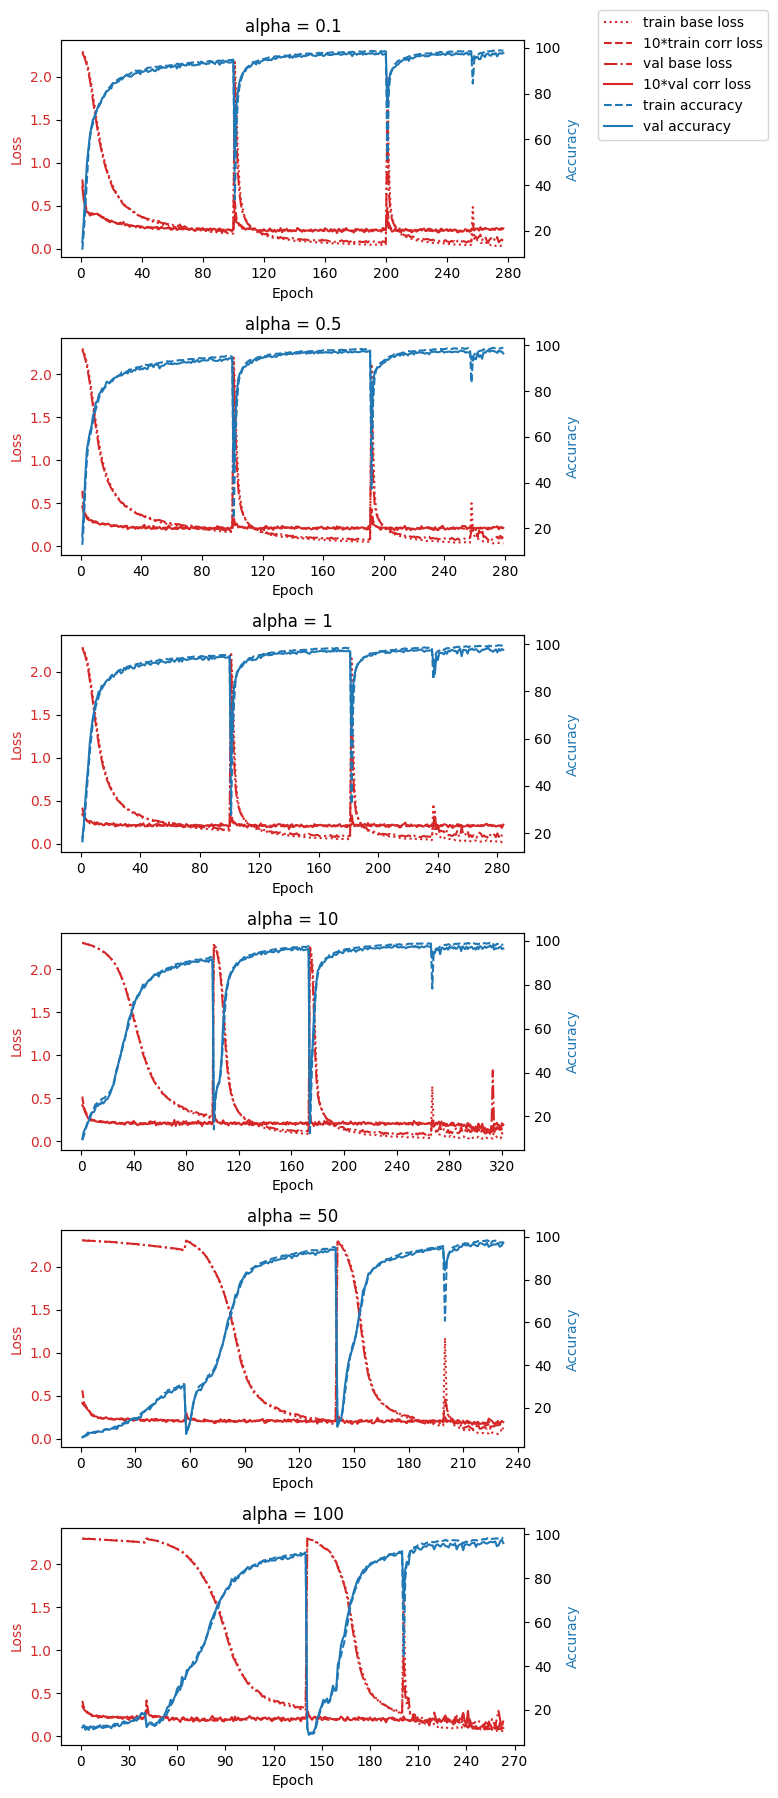

Learning rate = 5e-05


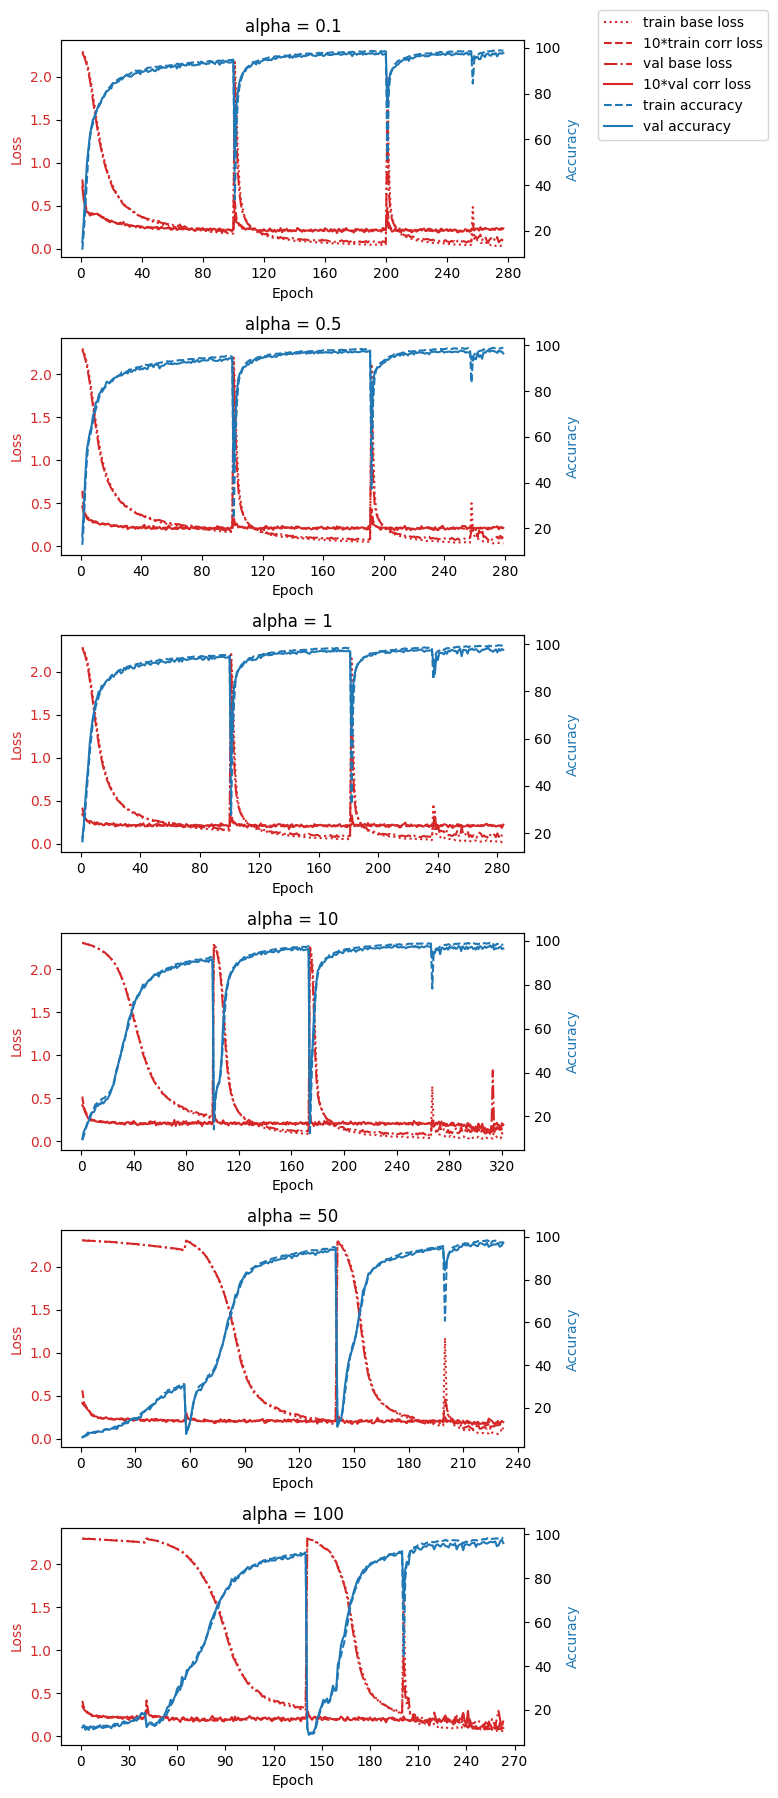

Learning rate = 0.0001


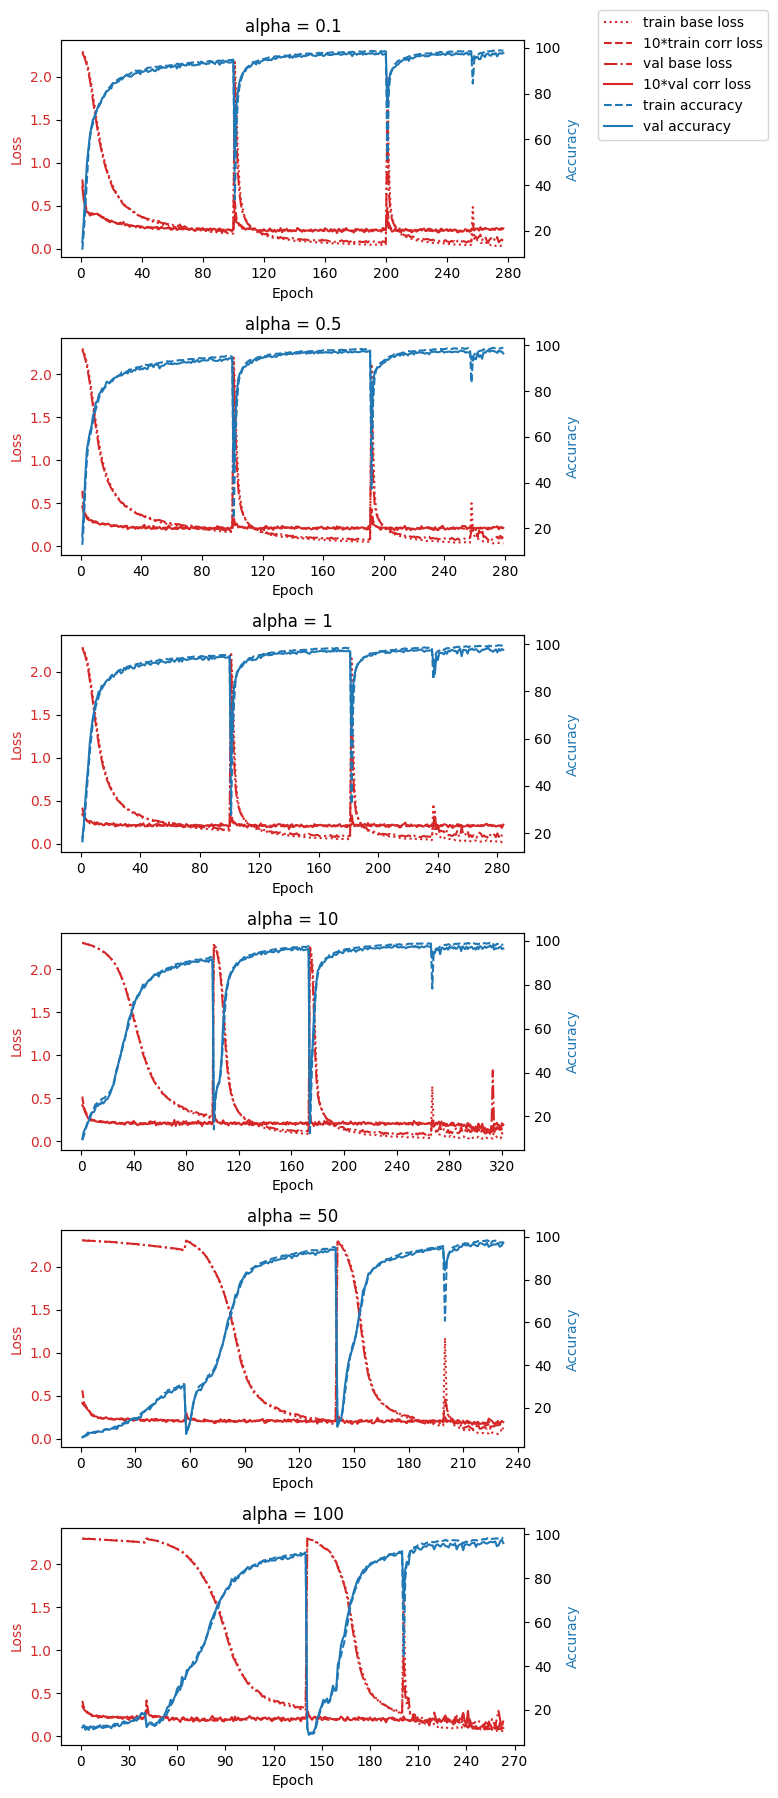

Learning rate = 0.005


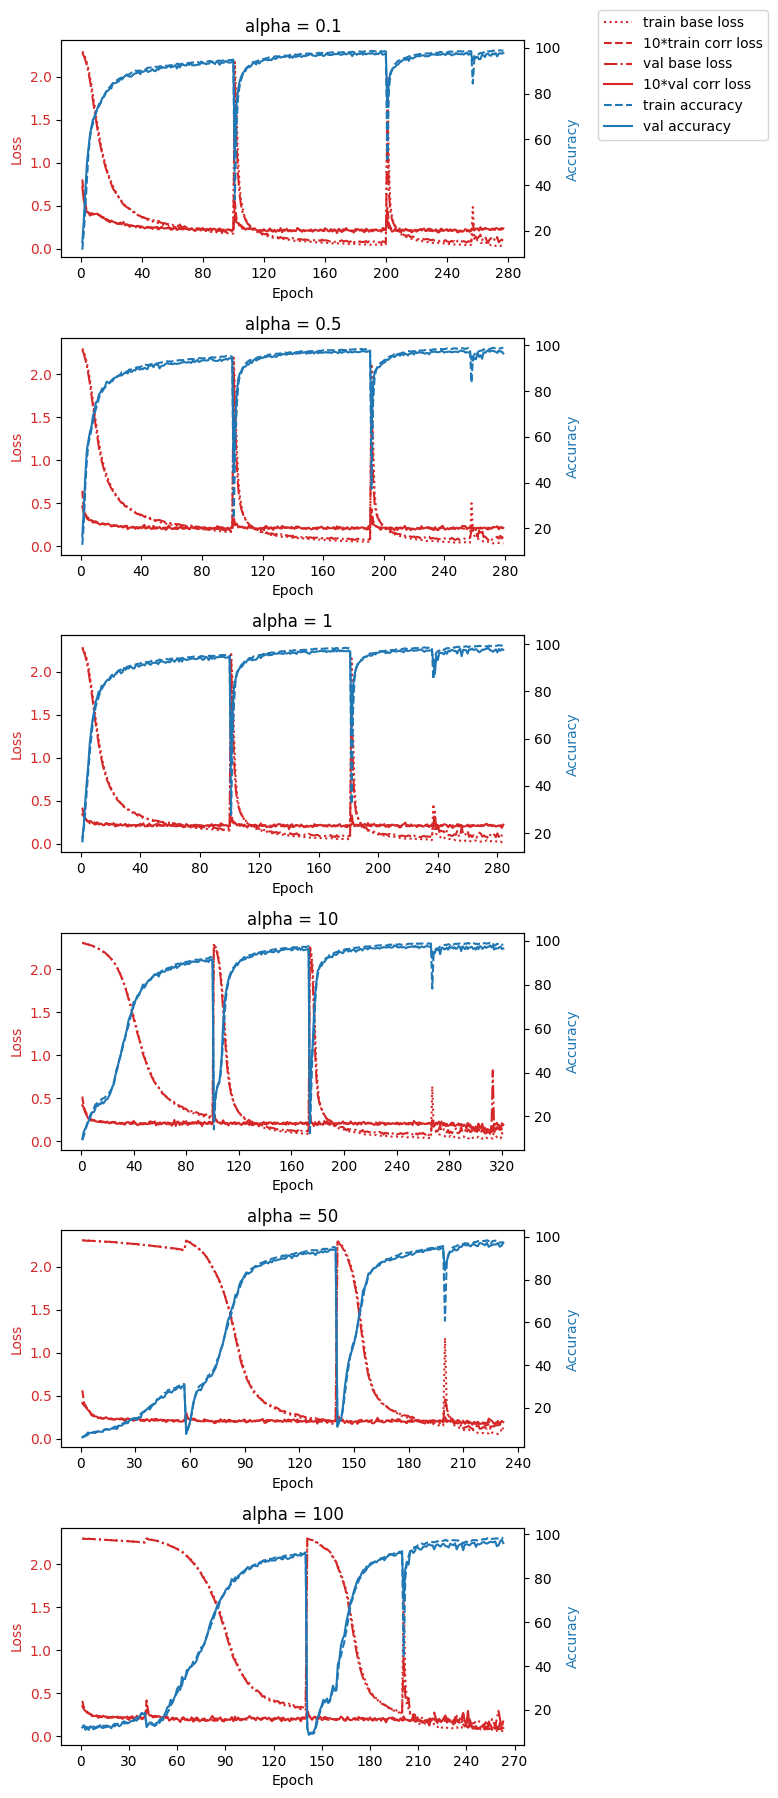

In [24]:
# plot training metrics
for lr in lrs:
    print(f"Learning rate = {lr}")
    plotter(alphas,model12_dict[lr],scaler=10)

Learning rate = 1e-05


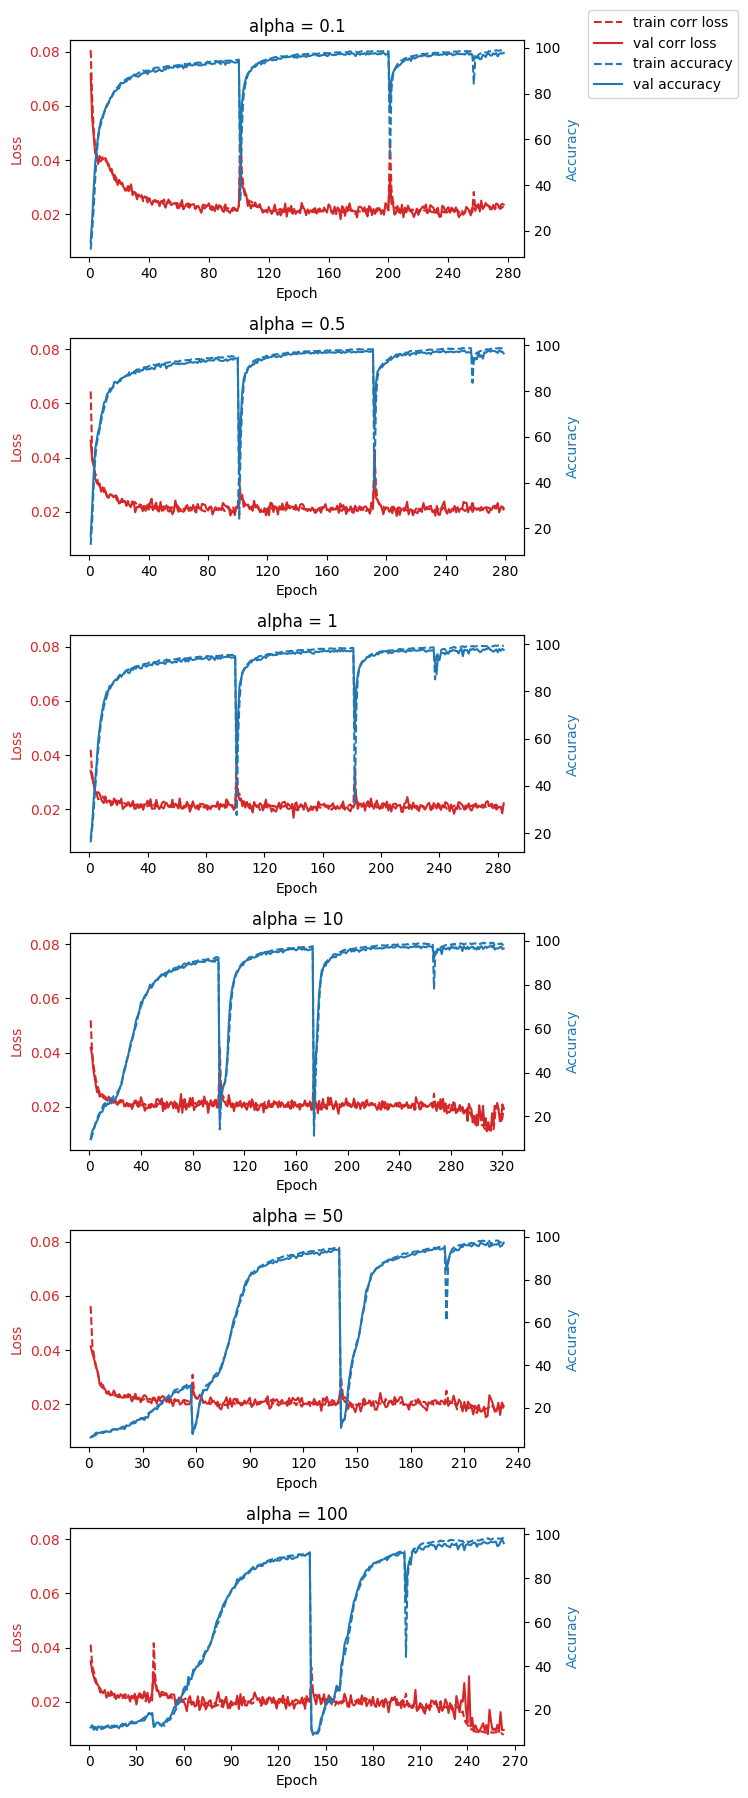

Learning rate = 5e-05


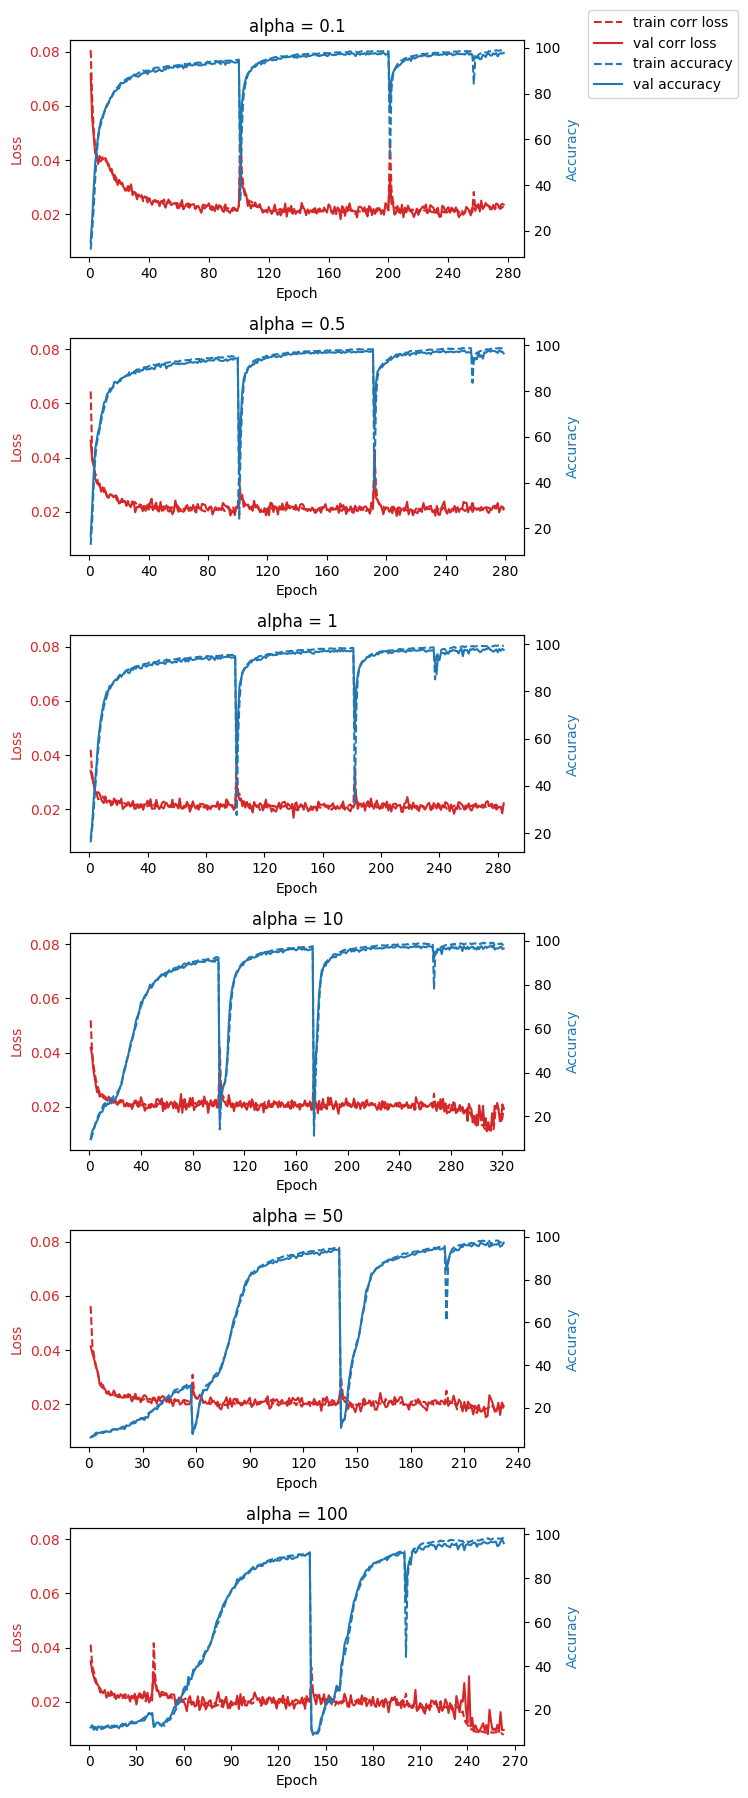

Learning rate = 0.0001


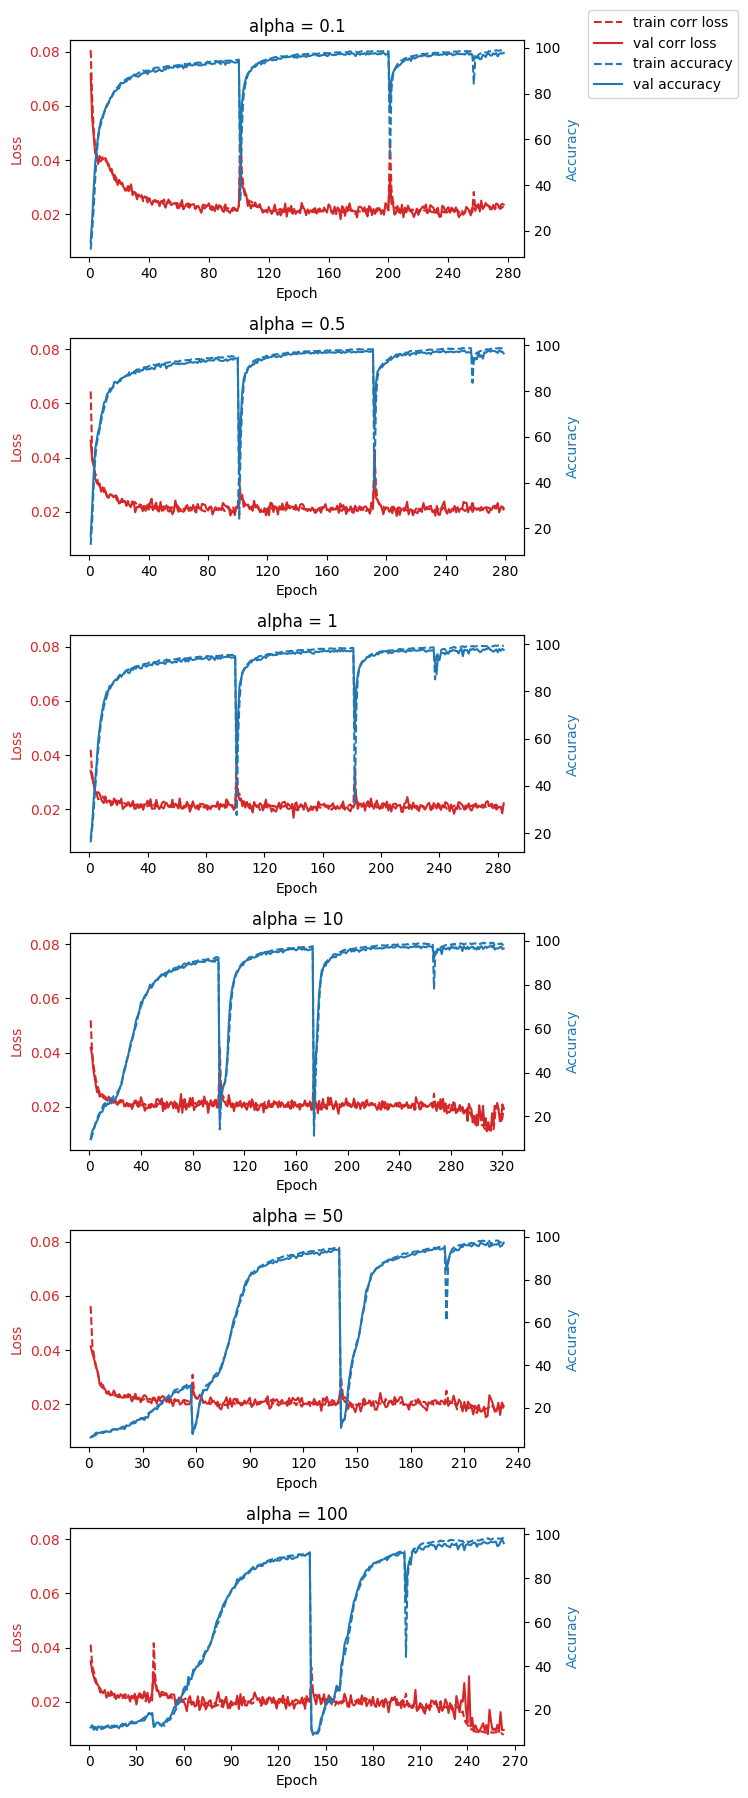

Learning rate = 0.005


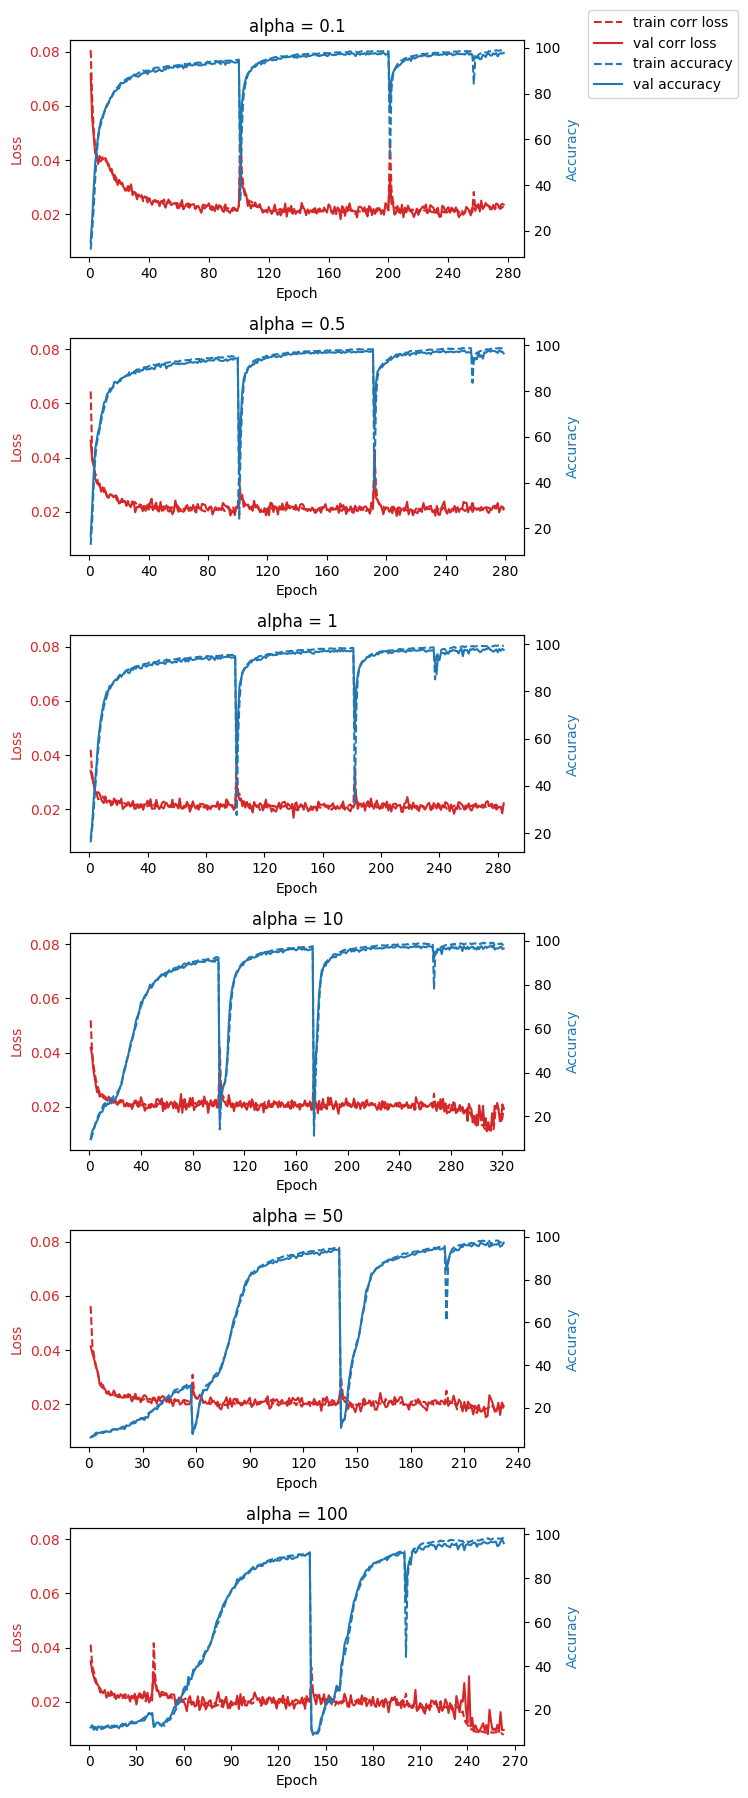

In [25]:
# plot training metrics
for lr in lrs:
    print(f"Learning rate = {lr}")
    plotter_corr(alphas,model12_dict[lr])

In [26]:
for i,lr in enumerate(lrs):
    print(f"lr = {lr}")
    # accuracy on test set - raw images
    tester(models12[i],alphas,raw_test_dataloader,"raw")

lr = 1e-05
Alpha = 0.1 Model:
Got 1271/10000 with accuracy 12.71

Alpha = 0.5 Model:
Got 2764/10000 with accuracy 27.64

Alpha = 1 Model:
Got 2480/10000 with accuracy 24.80

Alpha = 10 Model:
Got 5232/10000 with accuracy 52.32

Alpha = 50 Model:
Got 1372/10000 with accuracy 13.72

Alpha = 100 Model:
Got 992/10000 with accuracy 9.92

lr = 5e-05
Alpha = 0.1 Model:
Got 2602/10000 with accuracy 26.02

Alpha = 0.5 Model:
Got 2964/10000 with accuracy 29.64

Alpha = 1 Model:
Got 5265/10000 with accuracy 52.65

Alpha = 10 Model:
Got 2462/10000 with accuracy 24.62

Alpha = 50 Model:
Got 3460/10000 with accuracy 34.60

Alpha = 100 Model:
Got 4245/10000 with accuracy 42.45

lr = 0.0001
Alpha = 0.1 Model:
Got 1135/10000 with accuracy 11.35

Alpha = 0.5 Model:
Got 2945/10000 with accuracy 29.45

Alpha = 1 Model:
Got 1070/10000 with accuracy 10.70

Alpha = 10 Model:
Got 1895/10000 with accuracy 18.95

Alpha = 50 Model:
Got 2412/10000 with accuracy 24.12

Alpha = 100 Model:
Got 5865/10000 with accura